# Analysis of human-model similarity
Which models’ behavior were most similar to which other models’?

**The purpose of this notebook is to:** 
* analyse the similarity of predictions made by different models in comparison with human
* analyse various statistics on subset of the whole data based on accuracy to study if any interesting relationsip exists (*accuracy as overall human accuracy on each trial)
    * Adversarial (<50% accuracy with 95% CI)
    * Easy (0% <= accuracy <33.3%)
    * By chance (33.3% <= accuracy <66.7%)
    * Hard (66.7% <= accuracy <=100%)

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)
* Running `./summarize_human_model_behavior.ipynb` (PUBLIC USE)
* Running `./summarize_human_model_behavior_subset.ipynb` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm   

import  matplotlib
import seaborn as sns
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [6]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

## tally up all flagged sessions


In [7]:
## also load all human data into a big dataframe
HD = pd.concat([h.apply_exclusion_criteria(h.load_and_preprocess_data(p), verbose=True) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

97.5th percentile for streak length is 12.0.
There are 16 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 2 flagged IDs so far due to low accuracy.
There are 2 flagged IDs so far due to high RTs.
There are a total of 17 flagged IDs.
There are a total of 85 valid and complete sessions for towers.
97.5th percentile for streak length is 12.0.
There are 16 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 3 flagged IDs so far due to low accuracy.
There are 1 flagged IDs so far due to high RTs.
There are a total of 18 flagged IDs.
There are a total of 83 valid and complete sessions for containment.
97.5th percentile for streak length is 12.0.
There are 3 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequence

#### exclude subjects from familiarization
Run `familiariarization_exclusion.ipynb` to generate `excluded_games.csv`

In [8]:
bad_games = pd.read_csv(os.path.join(csv_dir,"humans/excluded_games.csv")).values[:,1]

In [9]:
bad_games

array(['0720-d5f527dc-d86a-4d88-af8f-b70ac9264fef',
       '1685-8963fea0-0d21-454b-8bbe-e9cbc792aa11',
       '4917-538725a5-383f-462b-9ab7-43b9473c9dcc',
       '7411-987b0a97-8a67-41a3-a3d8-d8f792c35ab5',
       '8383-e0582a4e-6498-4d91-bb29-2b6a363cc2e9',
       '8731-67e86658-28ff-4cc6-b722-9620e3b3ce43',
       '9784-7a67e88b-0416-4b55-8a72-9a0d99038c49',
       '9808-e983d3b8-75c3-428a-8182-f57fd645abb1',
       '9930-aa52e4be-e5e3-441a-9cb4-f1144d9e233f'], dtype=object)

In [10]:
print("Excluding {} rows for {} games".format(sum(HD['gameID'].isin(bad_games)), len(bad_games)))
HD = HD[~HD['gameID'].isin(bad_games)]

Excluding 900 rows for 9 games


### load model data

In [11]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [12]:
## clear out allModels_results.csv
model_res_paths = [p for p in model_res_paths if not "allModels_results.csv" in p]

In [13]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 248011 rows


In [14]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [15]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 0 duplicated rows!
Removed duplicates, 248011 rows left


In [16]:
# save model kinds to variable
# we will overwrite this further down
MODELS = list(MD["Model Kind"].unique())

In [17]:
print("We get the following kinds of models:")
display(MODELS)

We get the following kinds of models:


['OP3_OP3 encoder_0.0_Image Reconstruction_all_but_this_Image Reconstruction_0_same',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_Image Reconstruction_0_same',
 'OP3_OP3 encoder_0.0_Image Reconstruction_same_Image Reconstruction_0_same',
 'SVG_VGG_1.0_VAE_all_but_this_VAE_1_same',
 'SVG_VGG_2.0_VAE_all_but_this_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_but_this_VAE_0_same',
 'SVG_VGG_1.0_VAE_all_VAE_1_same',
 'SVG_VGG_2.0_VAE_all_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_VAE_0_same',
 'SVG_VGG_1.0_VAE_same_VAE_1_same',
 'SVG_VGG_2.0_VAE_same_VAE_2_same',
 'SVG_VGG_0.0_VAE_same_VAE_0_same',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_but_this_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_same_L2 on 2D position_0_same',
 'GNS-ransac_nan_nan_nan_nan_L2 on particle 3D positions_1_same',
 'RPIN_R-CNN_1.0_L2 on 2D posit

#### exclude bad stims (where model/human stims mismatched)

In [18]:
stim_comparision = pd.merge(pd.DataFrame(MD.groupby('Canon Stimulus Name')['Actual Outcome'].first()).reset_index(),pd.DataFrame(HD.groupby('stim_ID')['target_hit_zone_label'].first()).reset_index(),left_on='Canon Stimulus Name',right_on='stim_ID')

bad_stims = stim_comparision[stim_comparision['Actual Outcome'] != stim_comparision['target_hit_zone_label']]['Canon Stimulus Name']
print("There are {} bad stims".format(len(bad_stims)))

There are 37 bad stims


In [19]:
#Exclude bad stims
HD = HD[~HD['stim_ID'].isin(bad_stims)]
MD = MD[~MD['Canon Stimulus Name'].isin(bad_stims)]

In [20]:
#Also exclude stims from the rollingsliding ledge subset
HD = HD[~HD['stim_ID'].str.contains("rollingSliding_simple_ledge")]
MD = MD[~MD['Canon Stimulus Name'].str.contains("rollingSliding_simple_ledge")]

#### exclude familiriza stims (in order to do model/human stims comparison)

In [21]:
# human data trial accuracy
HD_accu = HD.groupby('stim_ID').agg({'correct':np.mean})
HD_accu

,correct
stim_ID,
pilot-containment-bowl_0001,0.566265
pilot-containment-bowl_0002,0.939759
pilot-containment-bowl_0003,0.939759
pilot-containment-bowl_0005,0.951807
pilot-containment-bowl_0007,0.819277
...,...
test19_0013,0.810811
test19_0015,0.351351
test19_0016,0.418919


In [22]:
# remove all familiarization trials data because human data don't have those
MD = MD[~MD['Canon Stimulus Name'].str.contains("familiarization")]

In [23]:
# model data trial accuracy
MD_accu = MD.groupby(['Canon Stimulus Name','Model']).agg({'correct':np.mean}).reset_index()
MD_models = MD.groupby(['Canon Stimulus Name','Model']).first()['Readout Train Data'].reset_index()

MD_accu = MD_accu.join(MD_models['Readout Train Data'])
MD_accu

,Canon Stimulus Name,Model,correct,Readout Train Data
0,pilot-containment-bowl_0000,CSWM,0.777778,containment
1,pilot-containment-bowl_0000,DEITFrozenLSTM,1.000000,containment
2,pilot-containment-bowl_0000,DEITFrozenMLP,1.000000,containment
3,pilot-containment-bowl_0000,DPI,1.000000,containment
4,pilot-containment-bowl_0000,GNS,1.000000,containment
...,...,...,...,...
17819,test19_0019,OP3,0.444444,clothiness
17820,test19_0019,RPIN,0.527778,clothiness
17821,test19_0019,SVG,0.075000,clothiness
17822,test19_0019,VGGFrozenLSTM,0.333333,clothiness


In [24]:
out = MD[MD['Canon Stimulus Name'].isin(HD['stim_ID'].tolist())]
yr = out[out['Canon Stimulus Name'].str.contains('yellow')]
MD

,Model,Readout Train Data,Readout Test Data,Train Accuracy,Test Accuracy,Readout Type,Predicted Prob_false,Predicted Prob_true,Predicted Outcome,Actual Outcome,Stimulus Name,Encoder Type,Dynamics Type,Encoder Pre-training Task,Encoder Pre-training Dataset,Encoder Pre-training Seed,Encoder Training Task,Encoder Training Dataset,Encoder Training Seed,Dynamics Training Task,Dynamics Training Dataset,Dynamics Training Seed,filename,Encoder_Pre-training Dataset,correct,Canon Stimulus Name,Encoder Training Dataset Type,Dynamics Training Dataset Type,Readout Train Data Type,ModelID,Model Kind
0,OP3,linking,linking,1.000000,0.480583,A,9.999980e-01,0.000002,0,1,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
1,OP3,linking,linking,1.000000,0.480583,A,9.999776e-01,0.000022,0,1,pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroo...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroo...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
2,OP3,linking,linking,1.000000,0.480583,A,3.345129e-10,1.000000,1,1,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,True,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
3,OP3,linking,linking,1.000000,0.480583,A,9.999989e-01,0.000001,0,0,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,True,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
4,OP3,linking,linking,1.000000,0.480583,A,2.348308e-02,0.976517,1,0,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20755,SVG,towers,towers,0.649723,0.446281,D,7.632269e-01,0.236773,0,0,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,True,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_same
20756,SVG,towers,towers,0.649723,0.446281,D,5.133288e-02,0.948667,1,1,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,True,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_same
20757,SVG,towers,towers,0.649723,0.446281,D,6.525511e-01,0.347449,0,1,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,False,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_

## Step 1:  Identify trials where humans are consistently below 50% accuracy (with α = 0.05 with classical parametric binomial proportion)

In [25]:
print('Minimum number of participants in any stimulus is ', HD.groupby(["scenarioName","stim_ID"]).count().min()['trialNum'])
# minimum number of experiment participant count

Minimum number of participants in any stimulus is  74


Here we created a dataframe called "correct_below_50", which is true when the 95% confidence interval for each stimulus is below the 50% cutoff. Since we have a sufficiently large sample size of minimum 74, we choose to deploy a classical parametric model to estimate the 95% confidence interval for the correctness of each stimulus.

In [26]:
# Calculate unbiased estimators of correctness for each stimulus under out presumption (using average rate of correctness).
correctness = HD.groupby('stim_ID').agg({'correct':np.mean})
scenarioName = HD.groupby('stim_ID').first()['scenarioName']
correctness = correctness.join(scenarioName)
correctness_count = HD.groupby('stim_ID').count()['trialNum']
correct_below_50 =  correctness[(correctness['correct'] + 1.96*(((correctness['correct'].multiply(1-correctness['correct']))).divide(correctness_count).apply(np.sqrt))) < 0.5].reset_index()
correct_below_50 

,stim_ID,correct,scenarioName
0,pilot-containment-bowl_0030,0.192771,containment
1,pilot-containment-box_0014,0.108434,containment
2,pilot-containment-box_0017,0.337349,containment
3,pilot-containment-box_0022,0.253012,containment
4,pilot-containment-cone-plate_0005,0.084337,containment
...,...,...,...
158,test17_0011,0.378378,clothiness
159,test17_0017,0.378378,clothiness
160,test18_0014,0.040541,clothiness
161,test19_0008,0.378378,clothiness


In [27]:
# how many trials' accuracy confidence interval are below 50% accuracy 
correct_below_50_dist = correct_below_50.groupby('scenarioName').count()
correct_below_50_dist

,stim_ID,correct
scenarioName,,
clothiness,19,19
collision,16,16
containment,18,18
dominoes,28,28
drop,24,24
linking,34,34
rollingsliding,5,5
towers,19,19


## Step 2: Measure the divergence between human accuracy and model accuracy

Over all trials that meet the criterion in step 1, we measure the divergence between human accuracy (which will be a proportion) and model accuracy (for each trial, there will also be proportion on the modeling side, as 1 if correct and 0 otherwise). Here, we use a simple statistic to compute is the root-mean-squared-error: sqrt(mean[(human_acc - model_accuracy)^2]), which represents "agreement between model and human for adversarial trials only" and there would be  88 (8 x 11) scenarios x models comparisons. 

In [28]:
HM_disc = MD_accu.merge(correct_below_50, how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc['diff'] = HM_disc['correct_model'] - HM_disc['correct_human']
HM_disc['root_sq'] = HM_disc['diff']**2
HM_scenario = HM_disc.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc = HM_disc.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc = HM_disc.join(HM_scenario)
HM_disc['rmse'] = np.sqrt(HM_disc['root_sq'])
HM_disc = HM_disc.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc

rmse
scenarioName Model                   
clothiness   CSWM            0.324798
             DEITFrozenLSTM  0.485064
             DEITFrozenMLP   0.473368
             DPI             0.310100
             GNS             0.574206
...                               ...
towers       OP3             0.325559
             RPIN            0.247317
             SVG             0.292170
             VGGFrozenLSTM   0.376746
             VGGFrozenMLP    0.376746

[88 rows x 1 columns]

In [29]:
# create a pivot table for heat map
HM_disc = pd.pivot_table(HM_disc.reset_index(), index=['scenarioName'], columns=['Model'], values=['rmse'])
HM_disc.columns = HM_disc.columns.droplevel(0)
HM_disc

Model,CSWM,DEITFrozenLSTM,DEITFrozenMLP,DPI,GNS,GNS-ransac,OP3,RPIN,SVG,VGGFrozenLSTM,VGGFrozenMLP
scenarioName,,,,,,,,,,,
clothiness,0.324798,0.485064,0.473368,0.310100,0.574206,0.574206,0.355935,0.399992,0.268872,0.417892,0.423740
collision,0.313904,0.358230,0.336658,0.404920,0.427083,0.364583,0.411126,0.306184,0.241384,0.371676,0.390884
containment,0.264911,0.489960,0.489960,0.395136,0.288710,0.440428,0.327904,0.268277,0.231191,0.304700,0.306188
dominoes,0.229308,0.307540,0.303571,0.375000,0.464286,0.563776,0.269274,0.267007,0.208482,0.256236,0.248299
drop,0.330197,0.396655,0.419504,0.547939,0.562724,0.564068,0.456093,0.279495,0.199787,0.311529,0.316159
linking,0.486244,0.461620,0.465192,0.359553,0.393753,0.421569,0.450372,0.300255,0.244306,0.444444,0.438820
rollingsliding,0.199298,0.465263,0.465263,0.340351,0.341053,0.293333,0.688187,0.142865,0.320132,0.643743,0.665965
towers,0.496663,0.305882,0.290334,0.276161,0.369040,0.292260,0.325559,0.247317,0.292170,0.376746,0.376746


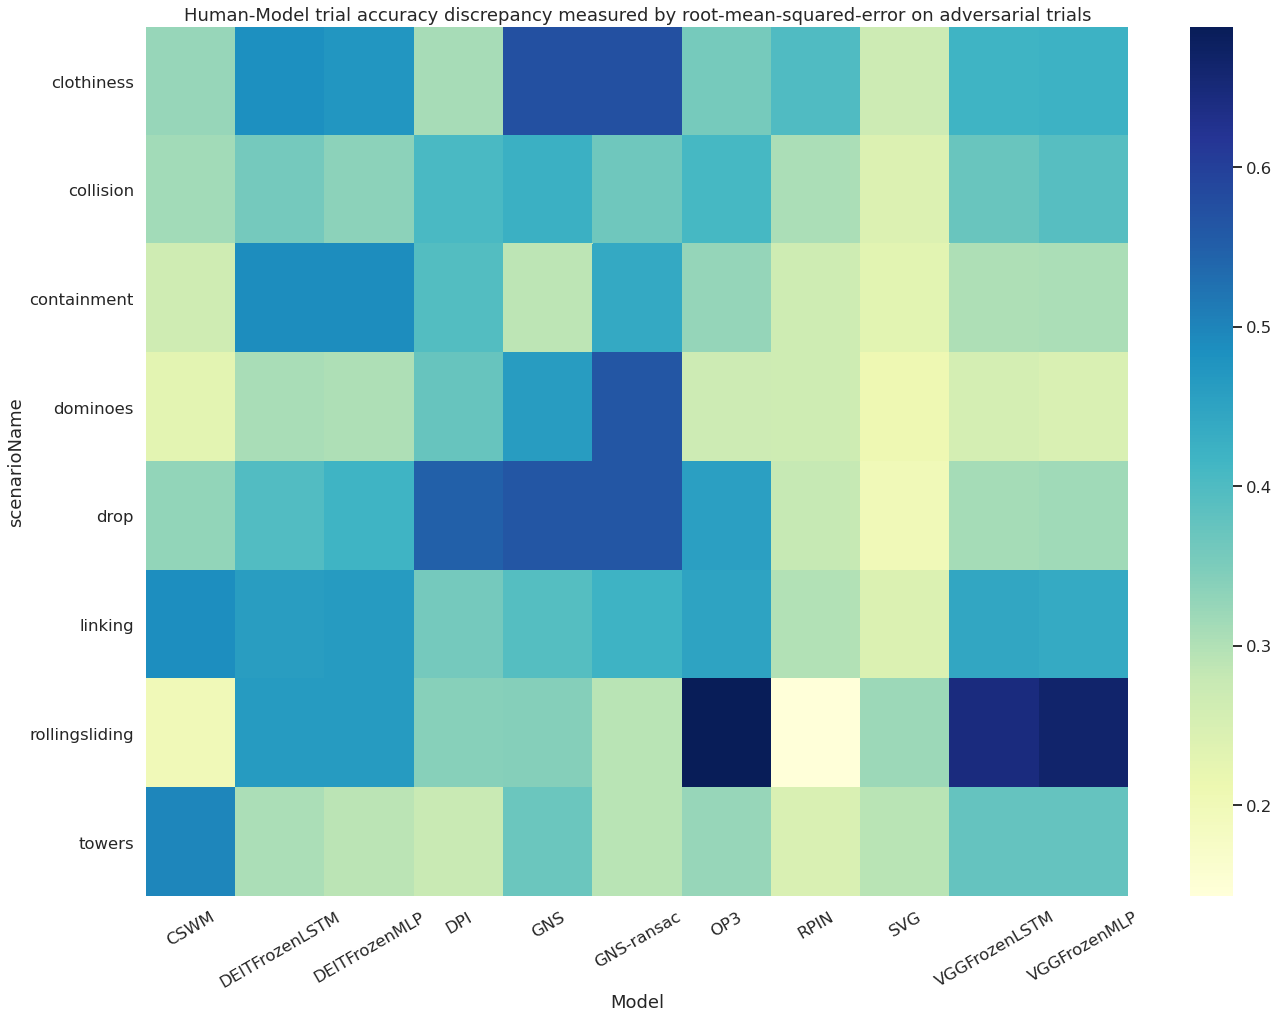

In [30]:
# plot the heat map
figure, ax = plt.subplots(figsize=(22,16)) 
ax = sns.heatmap(HM_disc, cmap="YlGnBu").set_title("Human-Model trial accuracy discrepancy measured by root-mean-squared-error on adversarial trials")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

In [31]:
HM_disc_all = MD_accu.merge(correctness.reset_index(), how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc_all['diff'] = HM_disc_all['correct_model'] - HM_disc_all['correct_human']
HM_disc_all['root_sq'] = HM_disc_all['diff']**2
HM_scenario_all = HM_disc_all.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc_all = HM_disc_all.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc_all = HM_disc_all.join(HM_scenario_all)
HM_disc_all['rmse'] = np.sqrt(HM_disc_all['root_sq'])
HM_disc_all = HM_disc_all.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc_all

rmse
scenarioName Model                   
clothiness   CSWM            0.275702
             DEITFrozenLSTM  0.401768
             DEITFrozenMLP   0.399994
             DPI             0.283179
             GNS             0.483191
...                               ...
towers       OP3             0.399395
             RPIN            0.249101
             SVG             0.267336
             VGGFrozenLSTM   0.275984
             VGGFrozenMLP    0.278063

[88 rows x 1 columns]

In [32]:
# create a pivot table for heat map
HM_disc_all = pd.pivot_table(HM_disc_all.reset_index(), index=['scenarioName'], columns=['Model'], values=['rmse'])
HM_disc_all.columns = HM_disc_all.columns.droplevel(0)
HM_disc_all

Model,CSWM,DEITFrozenLSTM,DEITFrozenMLP,DPI,GNS,GNS-ransac,OP3,RPIN,SVG,VGGFrozenLSTM,VGGFrozenMLP
scenarioName,,,,,,,,,,,
clothiness,0.275702,0.401768,0.399994,0.283179,0.483191,0.483252,0.361600,0.323241,0.247006,0.394451,0.397434
collision,0.357888,0.322522,0.322947,0.163357,0.173806,0.179905,0.461875,0.267415,0.274436,0.310654,0.307108
containment,0.349585,0.346390,0.347684,0.255636,0.249639,0.277858,0.400919,0.263809,0.286127,0.311209,0.310647
dominoes,0.361296,0.276958,0.279339,0.222619,0.385952,0.416905,0.384947,0.207894,0.260961,0.317646,0.318386
drop,0.330299,0.359403,0.363680,0.297348,0.357634,0.361075,0.440382,0.305663,0.287846,0.342270,0.341792
linking,0.361766,0.380870,0.381042,0.269897,0.282558,0.280129,0.418854,0.280560,0.239714,0.344160,0.345711
rollingsliding,0.359425,0.391054,0.380540,0.180851,0.210900,0.176745,0.492472,0.271765,0.357091,0.468969,0.472515
towers,0.279396,0.287047,0.284511,0.298802,0.267825,0.275747,0.399395,0.249101,0.267336,0.275984,0.278063


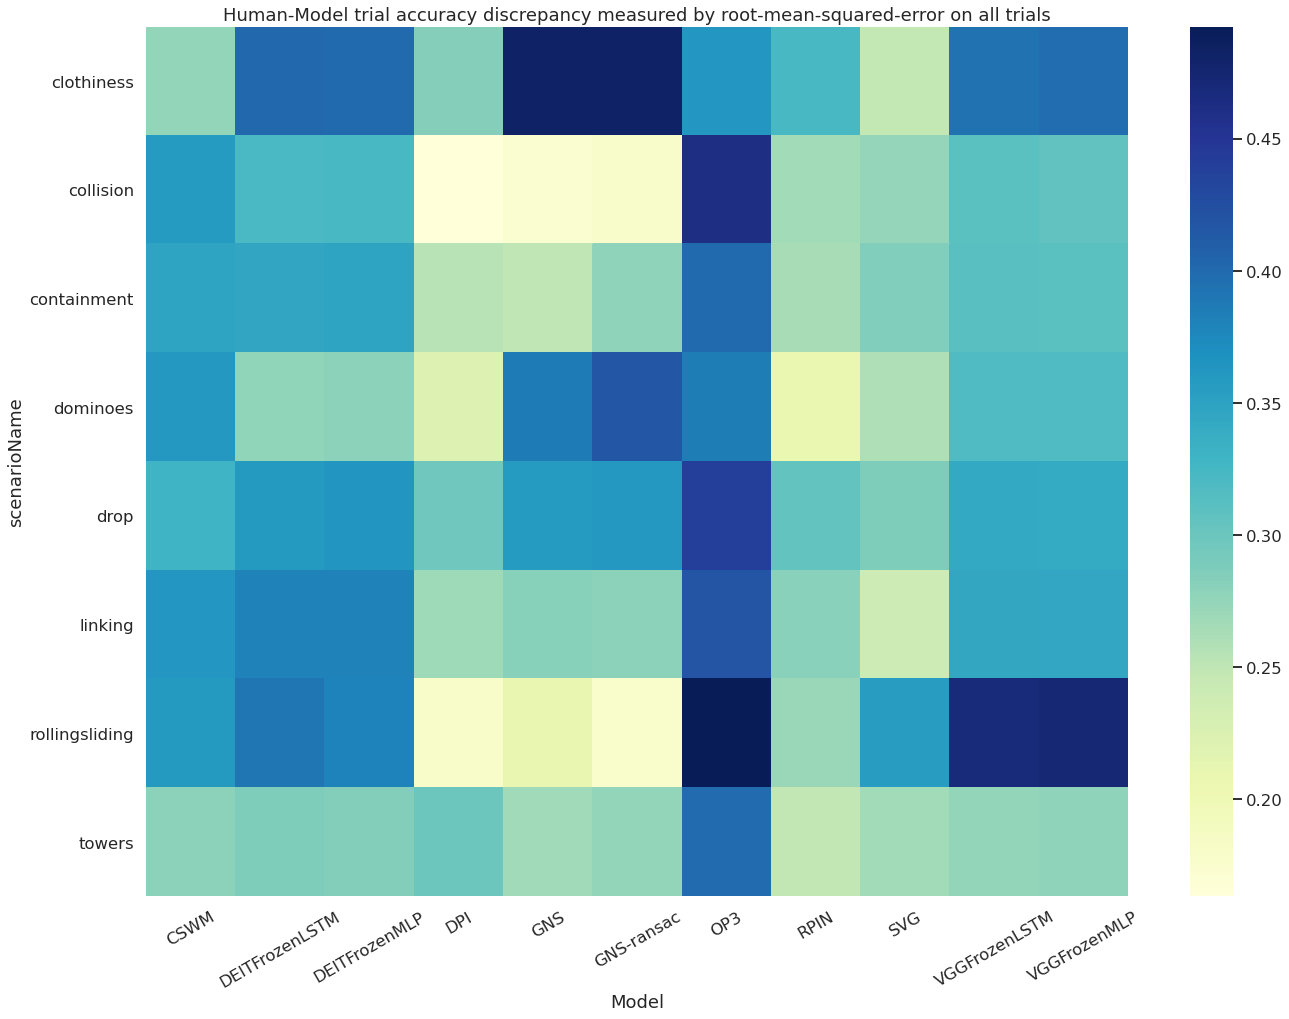

In [33]:
# plot the heat map
figure, ax = plt.subplots(figsize=(22,16)) 
ax = sns.heatmap(HM_disc_all, cmap="YlGnBu").set_title("Human-Model trial accuracy discrepancy measured by root-mean-squared-error on all trials")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

## Step 3: Scatter plot that visualizes the relationship between full-dataset model-human correlations and the model-human agreement on the adversarial trials only

Take the model-human correlation values that we already report at the scenario level (8 scenarios x 11 models) in the Results and create a scatter plot that visualizes the relationship between these full-dataset model-human correlations and the model-human agreement on the adversarial trials only. 

In [34]:
# human-model adversarial trials
HM_disc_adv = MD_accu.merge(correct_below_50, how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc_adv['diff'] = HM_disc_adv['correct_model'] - HM_disc_adv['correct_human']
HM_disc_adv['root_sq'] = HM_disc_adv['diff']**2
HM_scenario = HM_disc_adv.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc_adv = HM_disc_adv.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc_adv = HM_disc_adv.join(HM_scenario)
HM_disc_adv['rmse'] = np.sqrt(HM_disc_adv['root_sq'])
HM_disc_adv = HM_disc_adv.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc_adv['type'] = 'adv'
HM_disc_adv

rmse type
scenarioName Model                        
clothiness   CSWM            0.324798  adv
             DEITFrozenLSTM  0.485064  adv
             DEITFrozenMLP   0.473368  adv
             DPI             0.310100  adv
             GNS             0.574206  adv
...                               ...  ...
towers       OP3             0.325559  adv
             RPIN            0.247317  adv
             SVG             0.292170  adv
             VGGFrozenLSTM   0.376746  adv
             VGGFrozenMLP    0.376746  adv

[88 rows x 2 columns]

In [35]:
# human-model all trials
HM_disc_all = MD_accu.merge(correctness.reset_index(), how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc_all['diff'] = HM_disc_all['correct_model'] - HM_disc_all['correct_human']
HM_disc_all['root_sq'] = HM_disc_all['diff']**2
HM_scenario = HM_disc_all.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc_all = HM_disc_all.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc_all = HM_disc_all.join(HM_scenario)
HM_disc_all['rmse'] = np.sqrt(HM_disc_all['root_sq'])
HM_disc_all = HM_disc_all.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc_all['type'] = 'all'
HM_disc_all

rmse type
scenarioName Model                        
clothiness   CSWM            0.275702  all
             DEITFrozenLSTM  0.401768  all
             DEITFrozenMLP   0.399994  all
             DPI             0.283179  all
             GNS             0.483191  all
...                               ...  ...
towers       OP3             0.399395  all
             RPIN            0.249101  all
             SVG             0.267336  all
             VGGFrozenLSTM   0.275984  all
             VGGFrozenMLP    0.278063  all

[88 rows x 2 columns]

In [36]:
HM_diff = HM_disc_all
HM_diff['diff_prop'] = (HM_disc_all['rmse'] - HM_disc_adv['rmse'])/HM_disc_all['rmse']

# get the rmse differece
HM_diff = HM_diff.drop(columns = ['type', 'rmse'])
HM_diff

diff_prop
scenarioName Model                    
clothiness   CSWM            -0.178079
             DEITFrozenLSTM  -0.207325
             DEITFrozenMLP   -0.183438
             DPI             -0.095065
             GNS             -0.188361
...                                ...
towers       OP3              0.184869
             RPIN             0.007162
             SVG             -0.092893
             VGGFrozenLSTM   -0.365102
             VGGFrozenMLP    -0.354894

[88 rows x 1 columns]

In [37]:
# create the pivot table
HM_diff = pd.pivot_table(HM_diff.reset_index(), index=['scenarioName'], columns=['Model'], values=['diff_prop'])
HM_diff.columns = HM_diff.columns.droplevel(0)
HM_diff

Model,CSWM,DEITFrozenLSTM,DEITFrozenMLP,DPI,GNS,GNS-ransac,OP3,RPIN,SVG,VGGFrozenLSTM,VGGFrozenMLP
scenarioName,,,,,,,,,,,
clothiness,-0.178079,-0.207325,-0.183438,-0.095065,-0.188361,-0.188213,0.015666,-0.237442,-0.088521,-0.059424,-0.066187
collision,0.122900,-0.110716,-0.042455,-1.478745,-1.457240,-1.026528,0.109877,-0.144974,0.120436,-0.196429,-0.272789
containment,0.242212,-0.414475,-0.409210,-0.545699,-0.156514,-0.585084,0.182119,-0.016935,0.191996,0.020915,0.014355
dominoes,0.365318,-0.110421,-0.086751,-0.684492,-0.202961,-0.352288,0.300490,-0.284342,0.201097,0.193328,0.220132
drop,0.000307,-0.103650,-0.153499,-0.842756,-0.573462,-0.562190,-0.035676,0.085610,0.305923,0.089814,0.074997
linking,-0.344086,-0.212016,-0.220842,-0.332188,-0.393529,-0.504908,-0.075248,-0.070198,-0.019156,-0.291388,-0.269329
rollingsliding,0.445508,-0.189767,-0.222639,-0.881940,-0.617133,-0.659641,-0.397413,0.474304,0.103503,-0.372678,-0.409406
towers,-0.777629,-0.065619,-0.020465,0.075774,-0.377917,-0.059886,0.184869,0.007162,-0.092893,-0.365102,-0.354894


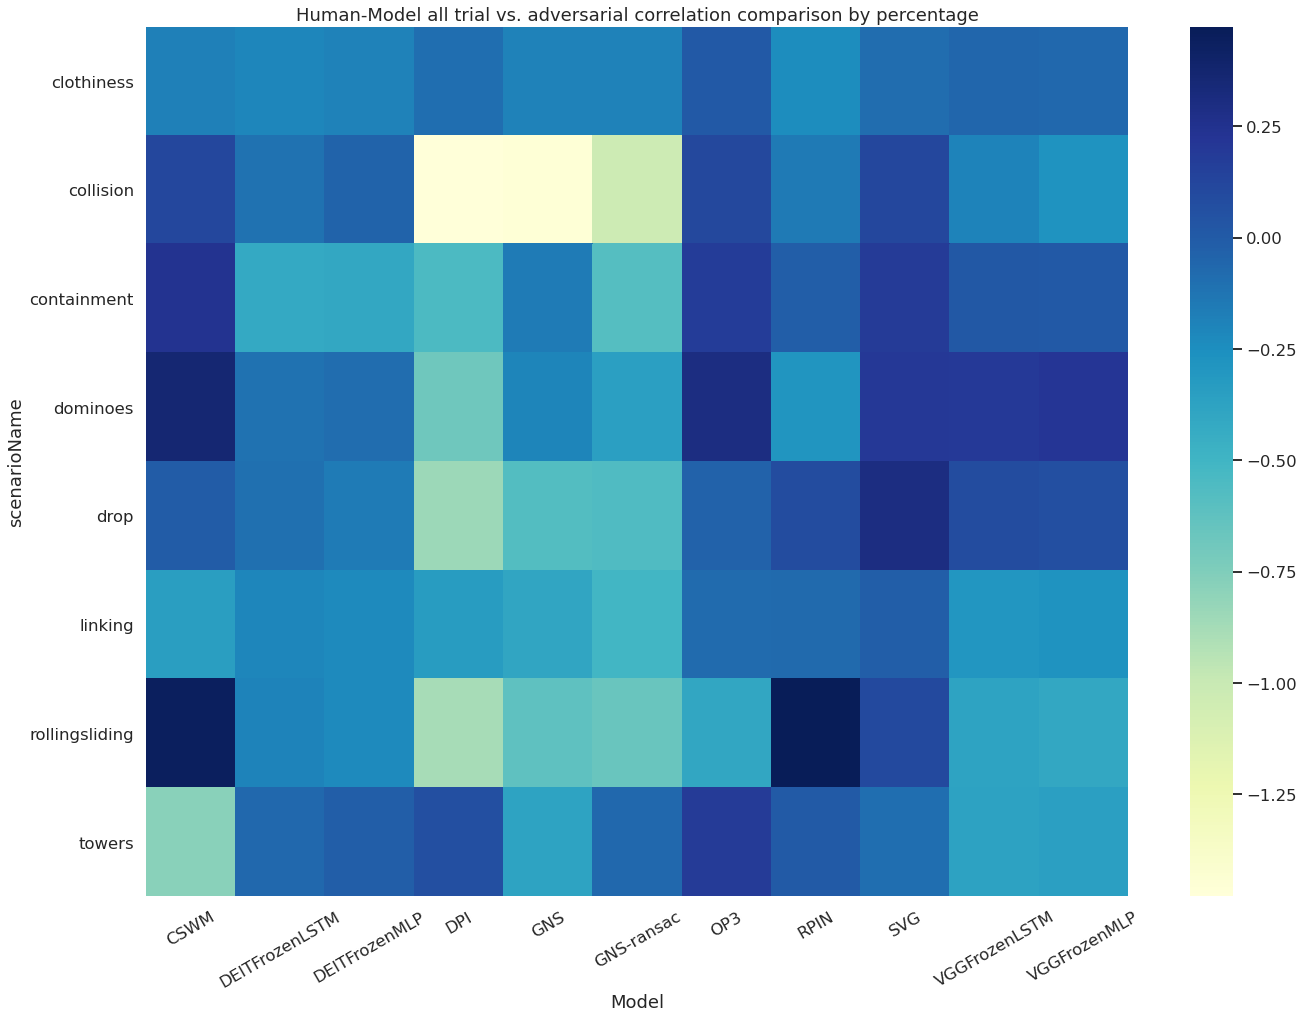

In [38]:
# plot the heat map
figure, ax = plt.subplots(figsize=(22,16)) 
ax = sns.heatmap(HM_diff, cmap="YlGnBu").set_title("Human-Model all trial vs. adversarial correlation comparison by percentage")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

To the extent that models we say are behaving "like humans" are also getting the adversarial trials wrong, then that bolsters our claim that our original metric is providing us a reasonable proxy for model-human agreement overall. Insofar as some models that are behaving in a "human-like" way on the full dataset deviate strongly from human responses on the "adversarial" trials (they're getting them right, when humans are getting them wrong), then it suggests that these examples are providing us with useful additional granular signal about those cases where current models and humans systematically disagree, and suggest the importance of further exploring what is going on in such cases.

## Step 4: Overall proportion of below-chance human trials (by scenario)

We report the overall proportion of below-chance human trials in the Results, with the proportion broken out by scenario type.

In [39]:
# get the the total number of the trails in each scenario type
trial_total = correctness.groupby('scenarioName').count()
trial_total

,correct
scenarioName,
clothiness,149
collision,150
containment,150
dominoes,150
drop,150
linking,150
rollingsliding,94
towers,149


In [40]:
# get the proportion of below-chance trials
correct_below_50_prop = correct_below_50_dist['stim_ID']/trial_total['correct']
correct_below_50_prop = correct_below_50_prop.to_frame().rename(columns={0: "prop"})
correct_below_50_prop

,prop
scenarioName,
clothiness,0.127517
collision,0.106667
containment,0.120000
dominoes,0.186667
drop,0.160000
linking,0.226667
rollingsliding,0.053191
towers,0.127517


## Step 5: Visualize Pearson correlation between human & model predictions on adversarial trials, contextualized among all trials (by showing Root Mean Square Error - RMSE)

In [43]:
# load data
# All
AMH = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies.csv"))
AMCK = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK.csv"))
AMRMSE = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse.csv"))
AH = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario.csv"))
ACK = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario.csv"))
AR = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCorrs_by_scenario.csv"))

# Adversarial
AMH_adv = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies_adv.csv"))
AMCK_adv = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK_adv.csv"))
AMRMSE_adv = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse_adv.csv"))
AH_adv = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario_adv.csv"))
ACK_adv = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario_adv.csv"))
AR_adv = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCorrs_by_scenario_adv.csv"))

# Hard
AMH_hard = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies_hard.csv"))
AMCK_hard = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK_hard.csv"))
AMRMSE_hard = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse_hard.csv"))
AH_hard = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario_hard.csv"))
ACK_hard = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario_hard.csv"))
AR_hard = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCorrs_by_scenario_hard.csv"))

# By chance
AMH_chance = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies_chance.csv"))
AMCK_chance = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK_chance.csv"))
AMRMSE_chance = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse_chance.csv"))
AH_chance = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario_chance.csv"))
ACK_chance = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario_chance.csv"))
AR_chance = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCorrs_by_scenario_chance.csv"))

# Easy
AMH_easy = pd.read_csv(os.path.join(csv_dir,"summary/model_human_accuracies_easy.csv"))
AMCK_easy = pd.read_csv(os.path.join(csv_dir,"summary/model_human_CohensK_easy.csv"))
AMRMSE_easy = pd.read_csv(os.path.join(csv_dir,"summary/model_human_pearsonsr_rmse_easy.csv"))
AH_easy = pd.read_csv(os.path.join(csv_dir,"summary/human_accuracy_by_scenario_easy.csv"))
ACK_easy = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCohensKs_by_scenario_easy.csv"))
AR_easy = pd.read_csv(os.path.join(csv_dir,"summary/human_pairwiseCorrs_by_scenario_easy.csv"))

In [44]:
# merge dataframes
_AMCK = AMCK[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]
_AMCK_adv = AMCK_adv[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]
_AMCK_hard = AMCK_hard[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]
_AMCK_chance = AMCK_chance[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]
_AMCK_easy = AMCK_easy[["ModelID","scenario","Cohens_k_lb","Cohens_k_med","Cohens_k_ub"]]

_AMRMSE = AMRMSE[["ModelID","scenario","RMSE","pearsons_r"]]
_AMRMSE_adv = AMRMSE_adv[["ModelID","scenario","RMSE","pearsons_r"]]
_AMRMSE_hard = AMRMSE_hard[["ModelID","scenario","RMSE","pearsons_r"]]
_AMRMSE_chance = AMRMSE_chance[["ModelID","scenario","RMSE","pearsons_r"]]
_AMRMSE_easy = AMRMSE_easy[["ModelID","scenario","RMSE","pearsons_r"]]

MH = pd.merge(AMH,_AMCK,on=['ModelID',"scenario"])
MH = pd.merge(MH,_AMRMSE,on=['ModelID',"scenario"])

MH_adv = pd.merge(AMH_adv,_AMCK_adv,on=['ModelID',"scenario"])
MH_adv = pd.merge(MH_adv,_AMRMSE_adv,on=['ModelID',"scenario"])

MH_hard = pd.merge(AMH_hard,_AMCK_hard,on=['ModelID',"scenario"])
MH_hard = pd.merge(MH_hard,_AMRMSE_hard,on=['ModelID',"scenario"])

MH_chance = pd.merge(AMH_chance,_AMCK_chance,on=['ModelID',"scenario"])
MH_chance = pd.merge(MH_chance,_AMRMSE_chance,on=['ModelID',"scenario"])

MH_easy = pd.merge(AMH_easy,_AMCK_easy,on=['ModelID',"scenario"])
MH_easy = pd.merge(MH_easy,_AMRMSE_easy,on=['ModelID',"scenario"])

In [45]:
SCENARIOS = sorted(MH['scenario'].unique())

In [46]:
#kick out SVG/RPIN additional seeds
MH = MH[~(((MH['Model'] == 'SVG') | (MH['Model'] == 'RPIN')) & (MH['Encoder Training Seed'] != 0.0))]
MH_adv = MH_adv[~(((MH_adv['Model'] == 'SVG') | (MH_adv['Model'] == 'RPIN')) & (MH_adv['Encoder Training Seed'] != 0.0))]
MH_hard = MH_hard[~(((MH_hard['Model'] == 'SVG') | (MH_hard['Model'] == 'RPIN')) & (MH_hard['Encoder Training Seed'] != 0.0))]
MH_chance = MH_chance[~(((MH_chance['Model'] == 'SVG') | (MH_chance['Model'] == 'RPIN')) & (MH_chance['Encoder Training Seed'] != 0.0))]
MH_easy = MH_easy[~(((MH_easy['Model'] == 'SVG') | (MH_easy['Model'] == 'RPIN')) & (MH_easy['Encoder Training Seed'] != 0.0))]

In [47]:
#choose readout and training type
MH_both = MH[(MH['Readout Type'] == "B") & (MH['Dynamics Training Dataset Type'] == "all")]
MH_both_adv = MH_adv[(MH_adv['Readout Type'] == "B") & (MH_adv['Dynamics Training Dataset Type'] == "all")]
MH_both_hard = MH_hard[(MH_hard['Readout Type'] == "B") & (MH_hard['Dynamics Training Dataset Type'] == "all")]
MH_both_chance = MH_chance[(MH_chance['Readout Type'] == "B") & (MH_chance['Dynamics Training Dataset Type'] == "all")]
MH_both_easy = MH_easy[(MH_easy['Readout Type'] == "B") & (MH_easy['Dynamics Training Dataset Type'] == "all")]

In [48]:
MH_readouts = MH[(MH['Dynamics Training Dataset Type'] == "all")]
MH_readouts_adv = MH_adv[(MH_adv['Dynamics Training Dataset Type'] == "all")]
MH_readouts_hard = MH_hard[(MH_hard['Dynamics Training Dataset Type'] == "all")]
MH_readouts_chance = MH_chance[(MH_chance['Dynamics Training Dataset Type'] == "all")]
MH_readouts_easy = MH_easy[(MH_easy['Dynamics Training Dataset Type'] == "all")]

In [49]:
MH_trainings = MH[(MH['Readout Type'] == "B")].copy()
MH_trainings_adv = MH_adv[(MH_adv['Readout Type'] == "B")].copy()
MH_trainings_hard = MH_hard[(MH_hard['Readout Type'] == "B")].copy()
MH_trainings_chance = MH_chance[(MH_chance['Readout Type'] == "B")].copy()
MH_trainings_easy = MH_easy[(MH_easy['Readout Type'] == "B")].copy()

In [50]:
#collapse model names HACK
MH_trainings['Model Kind'] = MH_trainings['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings['Model Kind'] = MH_trainings['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

MH_trainings_adv['Model Kind'] = MH_trainings_adv['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings_adv['Model Kind'] = MH_trainings_adv['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

MH_trainings_hard['Model Kind'] = MH_trainings_hard['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings_hard['Model Kind'] = MH_trainings_hard['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

MH_trainings_chance['Model Kind'] = MH_trainings_chance['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings_chance['Model Kind'] = MH_trainings_chance['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

MH_trainings_easy['Model Kind'] = MH_trainings_easy['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MH_trainings_easy['Model Kind'] = MH_trainings_easy['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

In [51]:
#set up model names
MODELS = dict(MH_both.groupby('Model Kind')['Model'].first())

assert np.all(MH_both.groupby('Model Kind')['ModelID'].count() == 8) # check for correctness

#rename these by hand if necessary
MODELS = {
 'SVG_VGG_0.0_VAE_all_VAE_0_same': 'SVG',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_Image Reconstruction_0_same': 'OP3',
 'CSWM_CSWM encoder_0.0_Contrastive_all_Contrastive_0_same': 'CSWM',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same': 'RPIN',
 'VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-mlp',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-lstm',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-mlp',
 'DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-lstm',
 'GNS_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS',
 'GNS-ransac_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS-R',
 'DPI_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'DPI',
}

In [52]:
# set up colors

COLORS = {
    'SVG':'orangered',
    'OP3':'darkorange',
    'CSWM':'gold',
    'RPIN':'greenyellow',
    'pDEIT-lstm':'royalblue',
    'pDEIT-mlp':'blue',
    'pVGG-lstm':'aquamarine',
    'pVGG-mlp':'turquoise',
    'GNS':'slateblue',
    'GNS-R':'orchid',
    'DPI':'hotpink',
}

In [53]:
# define pretty icon making mechanism

import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
def marker_from_svg(path):
    path, attributes = svg2paths(path)
    marker = parse_path(attributes[0]['d'])
#     marker = parse_path(path)
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

In [54]:
# set up icons

ICONS = {
     'clothiness':"<",
     'collision':">",
     'containment':"X",
     'dominoes':"p",
     'drop':"d",
     'linking':"h",
     'rollingsliding':"v",
     'towers':"P"
}

svg_dir = os.path.join(proj_dir,"figures/icons/SVG")

ICONS = {
     'clothiness':marker_from_svg(os.path.join(svg_dir,"clothiness.svg")),
     'collision':marker_from_svg(os.path.join(svg_dir,"collision.svg")),
     'containment':marker_from_svg(os.path.join(svg_dir,"containment.svg")),
     'dominoes':marker_from_svg(os.path.join(svg_dir,"dominoes.svg")),
     'drop':marker_from_svg(os.path.join(svg_dir,"drop.svg")),
     'linking':marker_from_svg(os.path.join(svg_dir,"linking.svg")),
     'rollingsliding':marker_from_svg(os.path.join(svg_dir,"rollingsliding.svg")),
     'towers':marker_from_svg(os.path.join(svg_dir,"towers.svg"))
}

In [55]:
# set up params for the visualization
from matplotlib import cm

cmap = cm.get_cmap('tab20_r')
# cmap = cmap(np.linspace(0, 1, 22))
cmap = cmap.colors


MARKER_SIZE = 20
MEAN_MULTIPLIER = 0.8
ALPHA = 0.2
SCEN_SHIFT = .06
N_ITER = 1000
FIGSIZE = (10,10)

In [56]:
def bootstrap_means(means):
    """Bootstraps over the means across scenarios to generate lower and upper confidence bounds"""
    bootstrapped_means = [np.mean(np.random.choice(means,size=len(AH),replace=True)) for _ in range(N_ITER)]
    lb = np.percentile(bootstrapped_means,2.5)
    ub = np.percentile(bootstrapped_means,97.5)
    mean = np.mean(means)
    boot_mean = np.mean(bootstrapped_means)
    boot_median = np.percentile(bootstrapped_means,50)
    return mean,lb,ub,boot_mean,boot_median

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


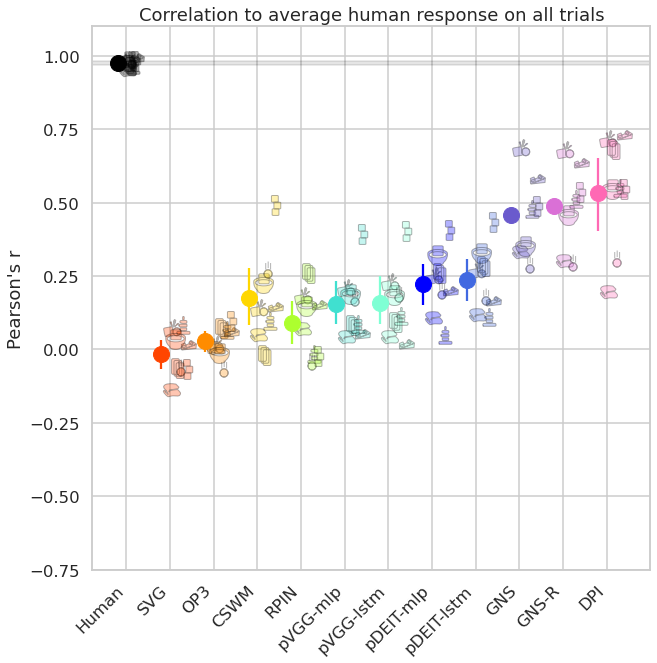

In [57]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
lb = AR['r_lb'].mean()
ub = AR['r_ub'].mean()
axis.axhspan(lb,ub,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AR[AR['scenario']==scenario]['r_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
# plot means
# human
mean = AR['r_mean'].mean()
lb = abs(mean-AR['r_lb'].mean())
ub = abs(mean-AR['r_ub'].mean())
assert AR['r_ub'].mean() == ub+mean
axis.errorbar(0-.2,mean,
              yerr=([lb],[ub]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER,
)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x+1+-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response on all trials")
axis.set_ylabel("Pearson's r")
axis.set_ybound((-0.75,1.1))
plt.savefig('corr_all.jpg')

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


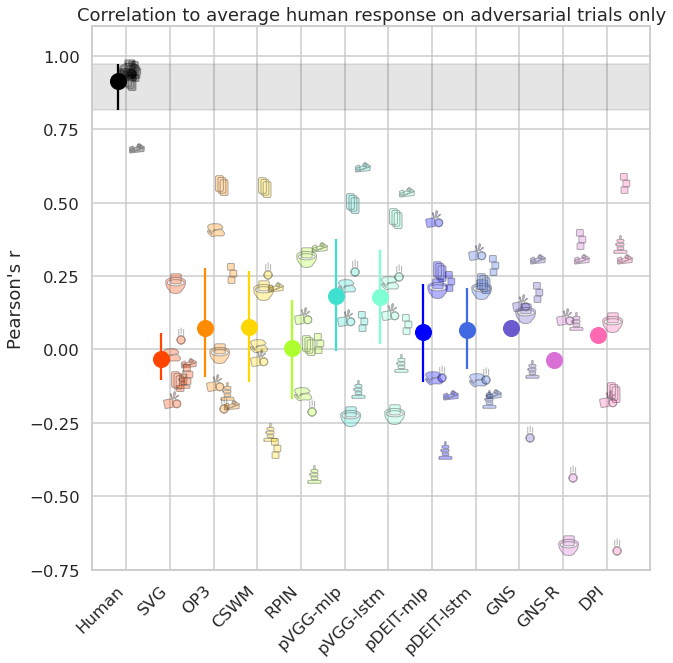

In [58]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
lb = AR_adv['r_lb'].mean()
ub = AR_adv['r_ub'].mean()
axis.axhspan(lb,ub,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AR_adv[AR_adv['scenario']==scenario]['r_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
              markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both_adv[(MH_both_adv['scenario']==scenario) & (MH_both_adv['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
# plot means
# human
mean = AR_adv['r_mean'].mean()
lb = abs(mean-AR_adv['r_lb'].mean())
ub = abs(mean-AR_adv['r_ub'].mean())
assert AR_adv['r_ub'].mean() == ub+mean
axis.errorbar(0-.2,mean,
              yerr=([lb],[ub]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER,
)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both_adv[(MH_both_adv['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x+1+-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response on adversarial trials only")
axis.set_ylabel("Pearson's r")
axis.set_ybound((-0.75,1.1))
plt.savefig('corr_adv.jpg')

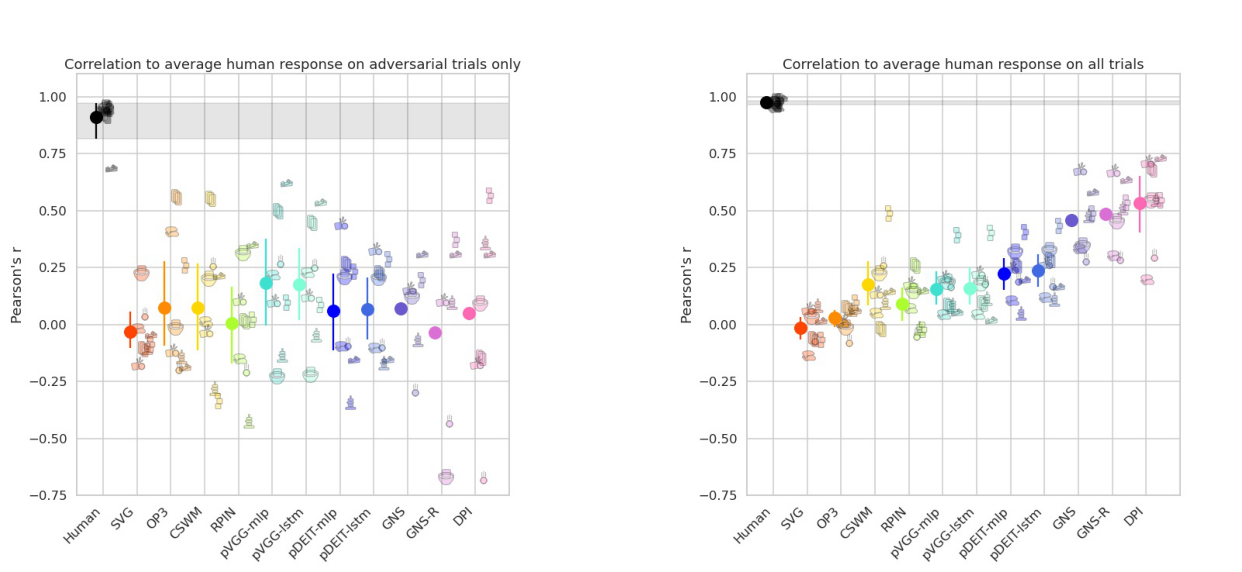

In [59]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('corr_adv.jpg')
img_B = mpimg.imread('corr_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

### Comparison of correlation between trials with different difficulty level, indicated by corresponding human accuracy

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


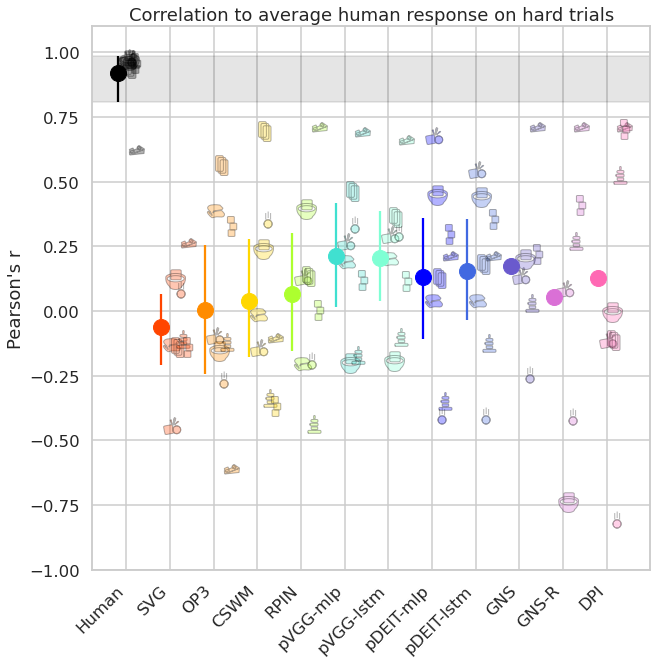

In [89]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
lb = AR_hard['r_lb'].mean()
ub = AR_hard['r_ub'].mean()
axis.axhspan(lb,ub,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AR_hard[AR_hard['scenario']==scenario]['r_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
              markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both_hard[(MH_both_hard['scenario']==scenario) & (MH_both_hard['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
# plot means
# human
mean = AR_hard['r_mean'].mean()
lb = abs(mean-AR_hard['r_lb'].mean())
ub = abs(mean-AR_hard['r_ub'].mean())
assert AR_hard['r_ub'].mean() == ub+mean
axis.errorbar(0-.2,mean,
              yerr=([lb],[ub]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER,
)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both_hard[(MH_both_hard['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x+1+-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response on hard trials")
axis.set_ylabel("Pearson's r")
axis.set_ybound((-1,1.1))
plt.savefig('corr_hard.jpg')

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


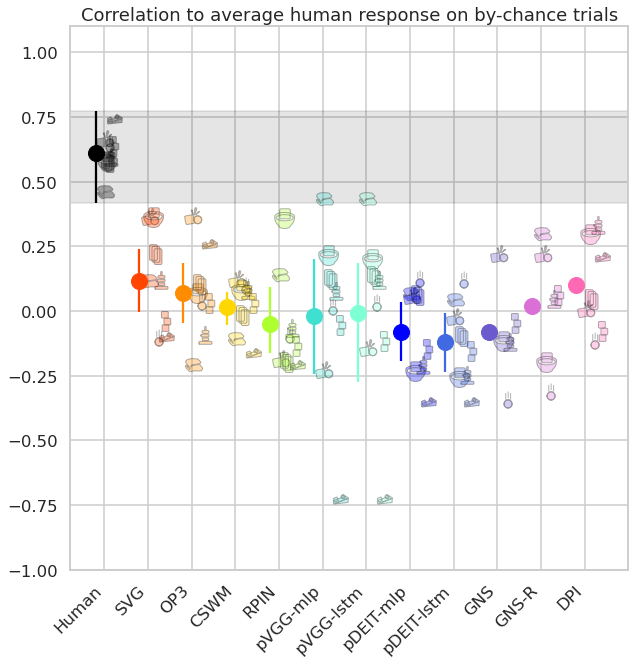

In [90]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
lb = AR_chance['r_lb'].mean()
ub = AR_chance['r_ub'].mean()
axis.axhspan(lb,ub,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AR_chance[AR_chance['scenario']==scenario]['r_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
              markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both_chance[(MH_both_chance['scenario']==scenario) & (MH_both_chance['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
# plot means
# human
mean = AR_chance['r_mean'].mean()
lb = abs(mean-AR_chance['r_lb'].mean())
ub = abs(mean-AR_chance['r_ub'].mean())
assert AR_chance['r_ub'].mean() == ub+mean
axis.errorbar(0-.2,mean,
              yerr=([lb],[ub]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER,
)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both_chance[(MH_both_chance['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x+1+-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response on by-chance trials")
axis.set_ybound((-1,1.1))
plt.savefig('corr_chance.jpg')

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


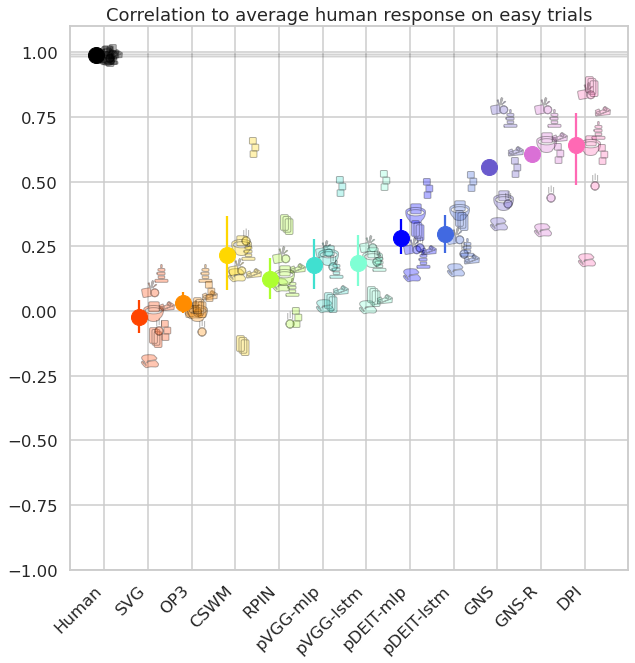

In [91]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
lb = AR_easy['r_lb'].mean()
ub = AR_easy['r_ub'].mean()
axis.axhspan(lb,ub,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AR_easy[AR_easy['scenario']==scenario]['r_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
              markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both_easy[(MH_both_easy['scenario']==scenario) & (MH_both_easy['Model Kind'] == model)]['pearsons_r'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
# plot means
# human
mean = AR_easy['r_mean'].mean()
lb = abs(mean-AR_easy['r_lb'].mean())
ub = abs(mean-AR_easy['r_ub'].mean())
assert AR_easy['r_ub'].mean() == ub+mean
axis.errorbar(0-.2,mean,
              yerr=([lb],[ub]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER,
)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both_easy[(MH_both_easy['Model Kind'] == model)]['pearsons_r'])
    axis.errorbar(x+1+-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Correlation to average human response on easy trials")
axis.set_ybound((-1,1.1))
plt.savefig('corr_easy.jpg')

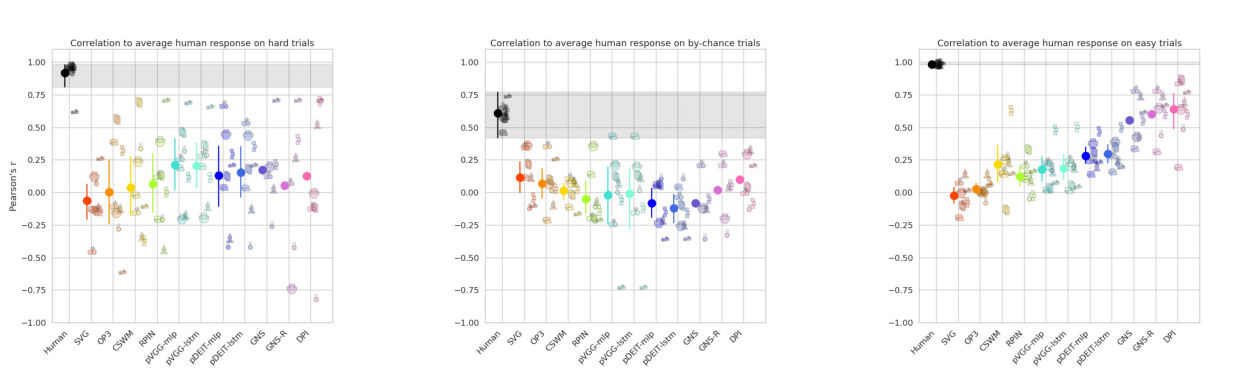

In [92]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('corr_hard.jpg')
img_B = mpimg.imread('corr_chance.jpg')
img_C = mpimg.imread('corr_easy.jpg')

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');
ax[2].imshow(img_C);
ax[2].axis('off');

#### (For comparsion - adversarial & all)

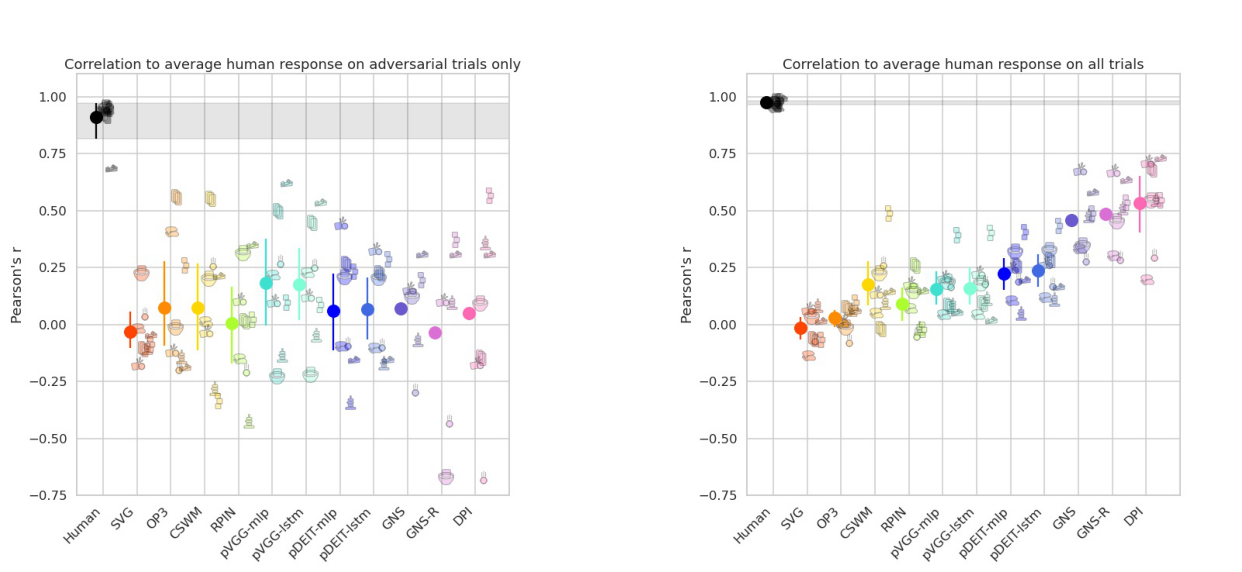

In [64]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('corr_adv.jpg')
img_B = mpimg.imread('corr_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [65]:
# remove used imgs
os.remove("corr_all.jpg") 
os.remove("corr_adv.jpg") 
print("Image files removed.")

Image files removed.


In [93]:
# remove used imgs
os.remove("corr_hard.jpg") 
os.remove("corr_chance.jpg") 
os.remove("corr_easy.jpg") 
print("Image files removed.")

Image files removed.


## Step 6: Computing noise ceiling on the adversarial trials only (same as paper) 

### Accuracy

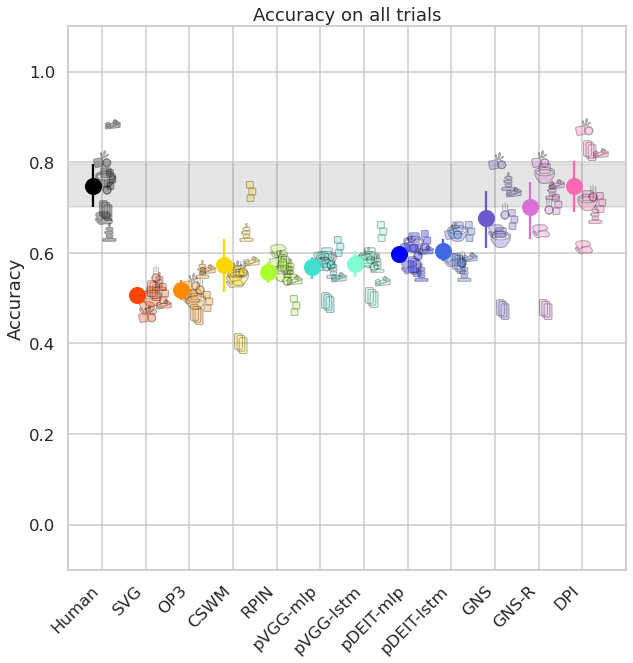

In [67]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AH[AH['scenario']==scenario]['obs_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['model_correct'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=scenario,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['model_correct'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)

#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Accuracy on all trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((-0.1,1.1))
plt.savefig('accu_all.jpg')

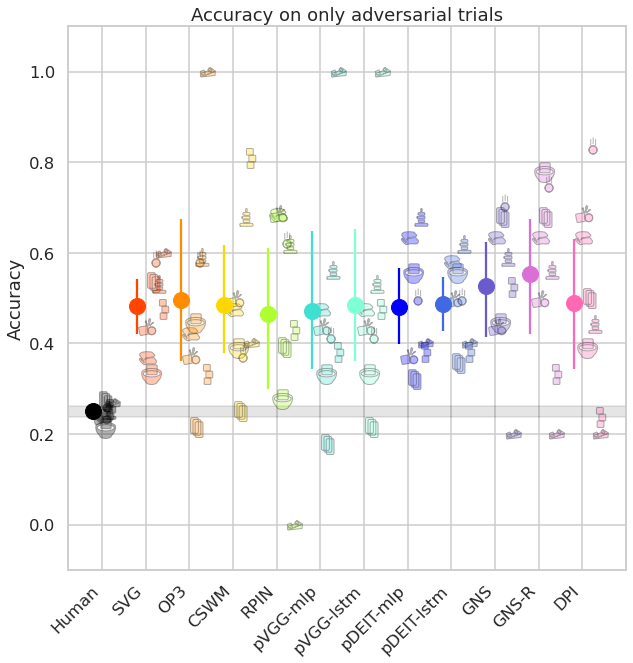

In [68]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH_adv['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,AH_adv[AH_adv['scenario']==scenario]['obs_mean'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both_adv[(MH_both_adv['scenario']==scenario) & (MH_both_adv['Model Kind'] == model)]['model_correct'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=scenario,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both_adv[(MH_both_adv['Model Kind'] == model)]['model_correct'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)

#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Accuracy on only adversarial trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((-0.1,1.1))
plt.savefig('accu_adv.jpg')

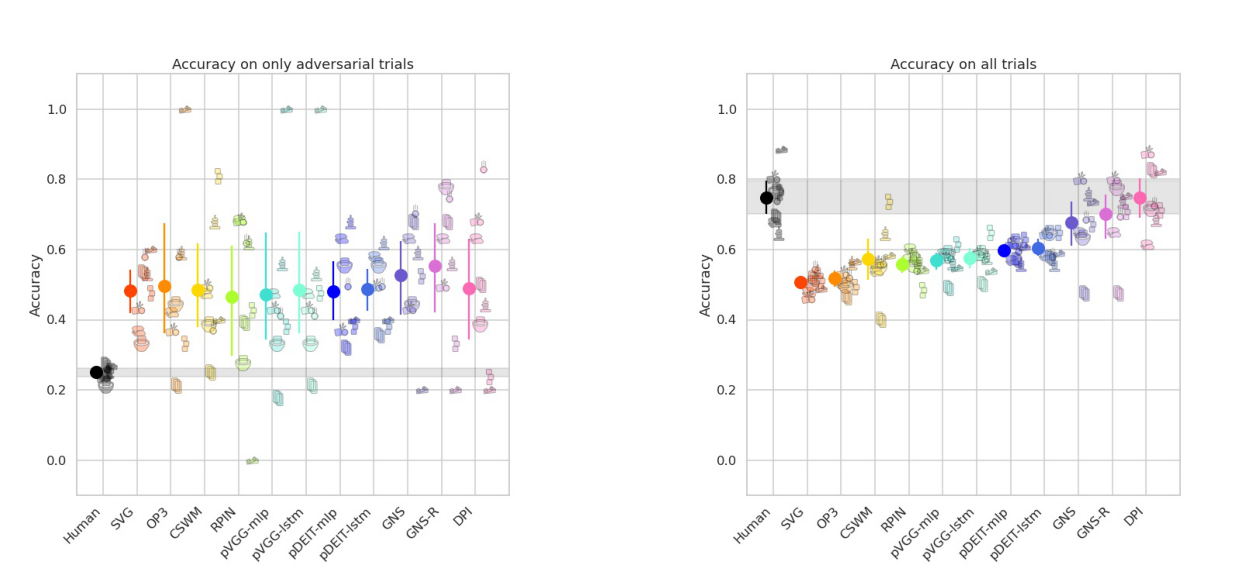

In [69]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('accu_adv.jpg')
img_B = mpimg.imread('accu_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [70]:
# remove used imgs after use
os.remove("accu_all.jpg") 
os.remove("accu_adv.jpg") 
print("Image files removed.")

Image files removed.


### Cohen's $\kappa$

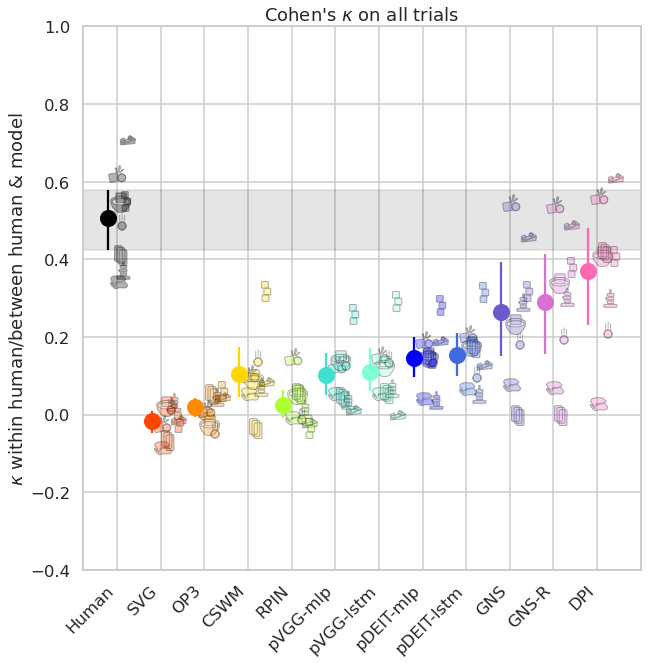

In [71]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(ACK['corr_med'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,ACK[ACK['scenario']==scenario]['corr_med'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['Cohens_k_med'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['Cohens_k_med'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Cohen's $\kappa$ on all trials")
axis.set_ylabel("$\kappa$ within human/between human & model")
axis.set_ybound((-.4,1))
plt.savefig('cohk_all.jpg')

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


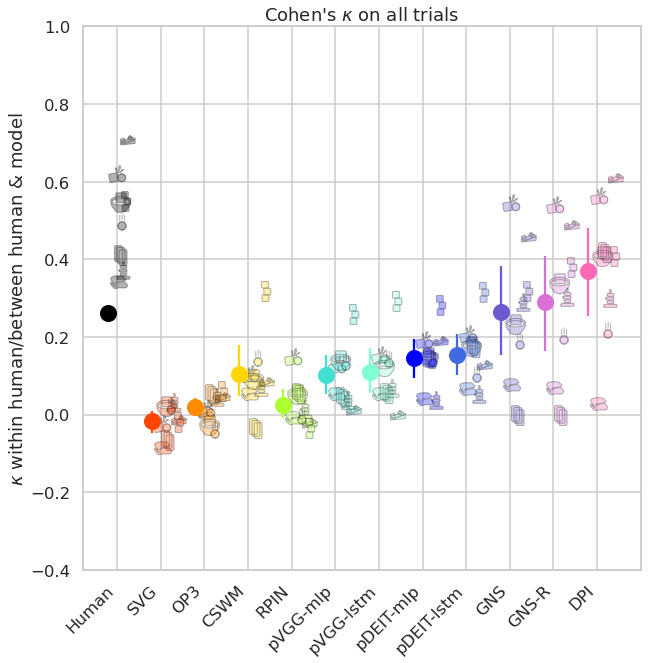

In [72]:
fig, axis = plt.subplots(figsize=FIGSIZE)

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(ACK_adv['corr_med'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

for si,scenario in enumerate(SCENARIOS):
    #plot human data
    axis.plot(0+si*.03,ACK[ACK['scenario']==scenario]['corr_med'],
              label="Human",
              marker=ICONS[scenario],
              fillstyle='full',
#               markerfacecolor="black",
              color="black",
              alpha=.3, 
              ms=MARKER_SIZE)
    #plot model data
    for x,(model,model_name) in enumerate(MODELS.items()):
        axis.plot(x+1+si*SCEN_SHIFT,MH_both[(MH_both['scenario']==scenario) & (MH_both['Model Kind'] == model)]['Cohens_k_med'],
                  marker=ICONS[scenario],
                  fillstyle='full',
                  markerfacecolor=COLORS[model_name],
                  color="black",
                  label=model_name,
                  alpha=.3,
                  ms=MARKER_SIZE)
#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS.items()):
    mean,lb,ub,_,_ = bootstrap_means(MH_both[(MH_both['Model Kind'] == model)]['Cohens_k_med'])
    axis.errorbar(x+1-.2,mean,([abs(mean-lb)],[abs(mean-ub)]),
      marker="o",
      color=COLORS[model_name],
      label=model_name,
      ms=MARKER_SIZE*MEAN_MULTIPLIER)
   
#add labels
axis.set_xticks(np.arange(len(MODELS)+1))
axis.set_xticklabels(["Human"] + list(MODELS.values()),rotation=45,ha='right')
axis.set_title("Cohen's $\kappa$ on all trials")
axis.set_ylabel("$\kappa$ within human/between human & model")
axis.set_ybound((-.4,1))
plt.savefig('cohk_adv.jpg')

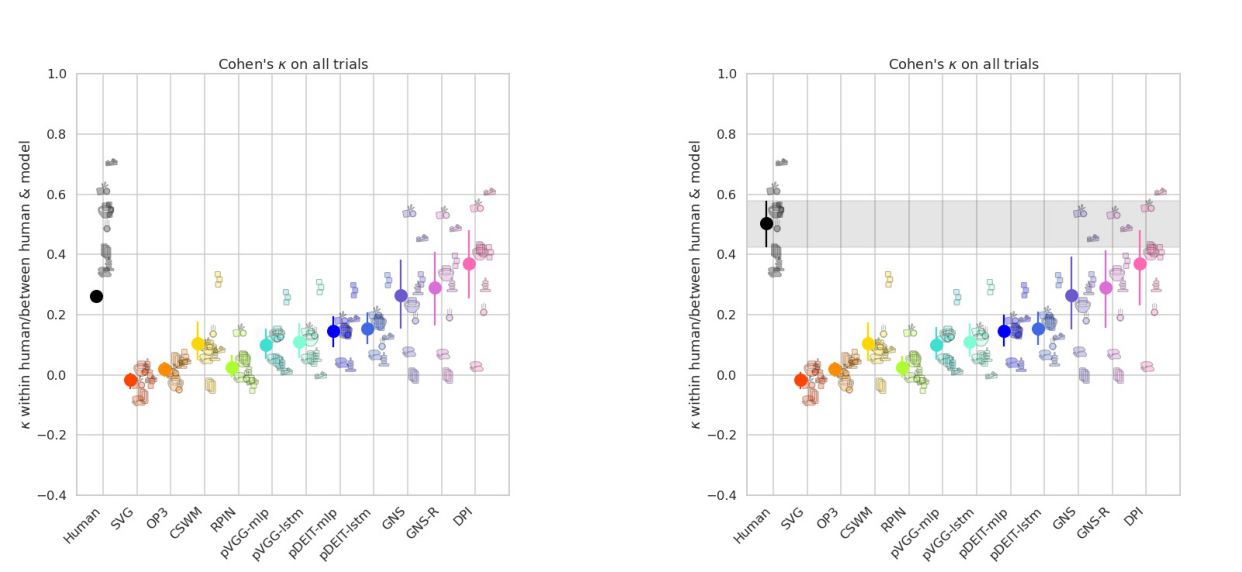

In [73]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('cohk_adv.jpg')
img_B = mpimg.imread('cohk_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [74]:
# remove used imgs after use
os.remove("cohk_all.jpg") 
os.remove("cohk_adv.jpg") 
print("Image files removed.")

Image files removed.


### Readout type
only vision models

view + simulation is not better than just view

compare B & C on per model basis
paired lines
average across scenario
col: model
    subcol0 C
    subcol1 B
    subcol2 A
y accuracy
color: model

In [75]:
# get the models we have more than one readout type for
readout_models = [m for m,c in (MH_readouts.groupby('Model Kind')['Readout Type'].nunique()).items() if c >= 2]

In [76]:
MODELS_readout = {key:value for key,value in MODELS.items() if key in readout_models}

In [77]:
READOUTS = ["C","B","A"]

READOUT_MARKER = {
    'A': '^',
    'B': 'o',
    'C': 's'
}

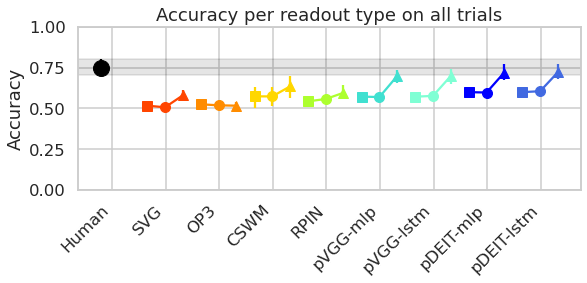

In [78]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_readout.items()):
    means = []
    lbs = []
    ubs = []
    for o,readout in enumerate(READOUTS):
        mean,lb,ub,_,_ = bootstrap_means(MH_readouts[(MH_readouts['Model Kind'] == model)&
                                                     (MH_readouts['Readout Type'] == readout)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker=READOUT_MARKER[readout],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_readout)+1))
axis.set_xticklabels(["Human"] + list(MODELS_readout.values()),rotation=45,ha='right')
axis.set_title("Accuracy per readout type on all trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((0,1))
plt.savefig("readout_accu_all.jpg", bbox_inches='tight')

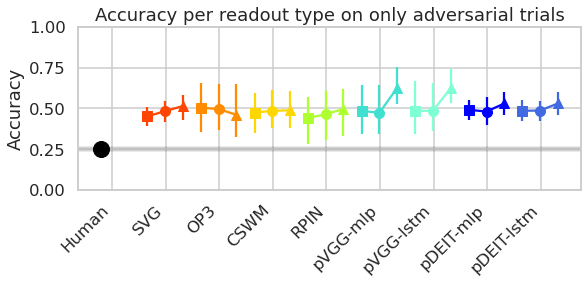

In [79]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH_adv['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_readout.items()):
    means = []
    lbs = []
    ubs = []
    for o,readout in enumerate(READOUTS):
        mean,lb,ub,_,_ = bootstrap_means(MH_readouts_adv[(MH_readouts_adv['Model Kind'] == model)&
                                                     (MH_readouts_adv['Readout Type'] == readout)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker=READOUT_MARKER[readout],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_readout)+1))
axis.set_xticklabels(["Human"] + list(MODELS_readout.values()),rotation=45,ha='right')
axis.set_title("Accuracy per readout type on only adversarial trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((0,1))
plt.savefig("readout_accu_adv.jpg", bbox_inches='tight')

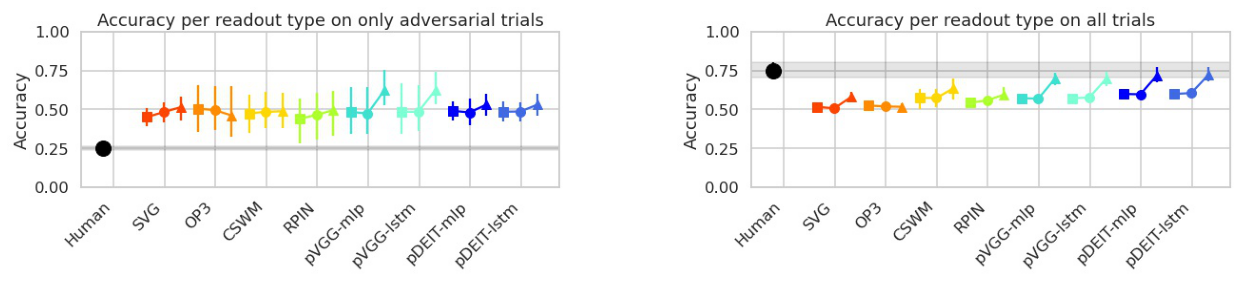

In [80]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('readout_accu_adv.jpg')
img_B = mpimg.imread('readout_accu_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [81]:
# remove used imgs after use
os.remove("readout_accu_adv.jpg") 
os.remove("readout_accu_all.jpg") 
print("Image files removed.")

Image files removed.


### Training Type
do some models generalize better than others? Are any of the scenarios more important to include
points for scenarios
maybe: same as cohens with interconnected lines
or paired barplot with errorbars

or two plots: connected lines
* averaging across scenarios (are some models better at generalizing?)
* are there scenarios that are important to include?

In [82]:
# get the models we have more than one readout type for
trainings_models = [m for m,c in (MH_trainings.groupby('Model Kind')['Dynamics Training Dataset Type'].nunique()).items() if c >= 2]

In [83]:
MODELS_trainings = {key:value for key,value in MODELS.items() if key in trainings_models}

In [84]:
TRAININGS = ["all","all_but_this","same"]

TRAINING_FILL = {
    'all': 'full',
    'all_but_this': 'left',
    'same': 'none'
}

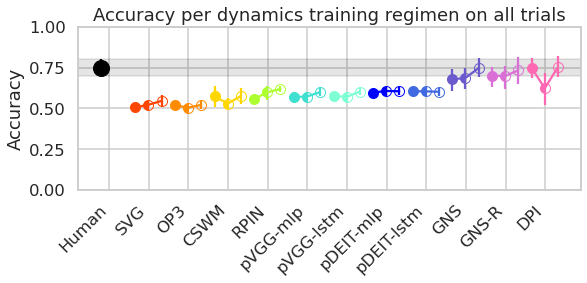

In [85]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_trainings.items()):
    means = []
    lbs = []
    ubs = []
    for o,training in enumerate(TRAININGS):
        mean,lb,ub,_,_ = bootstrap_means(MH_trainings[(MH_trainings['Model Kind'] == model)&
                                                     (MH_trainings['Dynamics Training Dataset Type'] == training)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker="o",
          fillstyle=TRAINING_FILL[training],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_trainings)+1))
axis.set_xticklabels(["Human"] + list(MODELS_trainings.values()),rotation=45,ha='right')
axis.set_title("Accuracy per dynamics training regimen on all trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((0,1))
plt.savefig("training_accu_all.jpg",bbox_inches='tight')

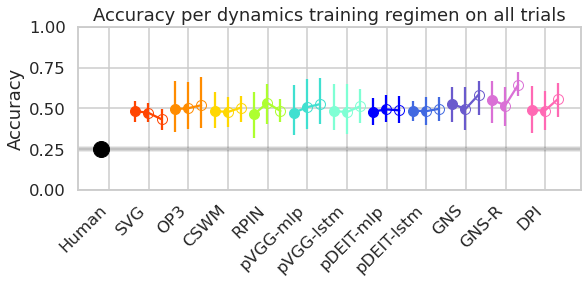

In [86]:
fig, axis = plt.subplots(figsize=(9,3))

# human zone
## human
mean_human,lb_human,ub_human,_,_ = bootstrap_means(AH_adv['obs_mean'])
axis.axhspan(lb_human,ub_human,
              color="black",
               alpha=0.1)

#plot means
## human
lb_human = abs(mean_human - lb_human) #as we error relative to mean
ub_human = abs(mean_human - ub_human)
axis.errorbar(0-.2,mean_human,
              yerr=([lb_human],[ub_human]),
              label="Human",
              color="black",
              marker = "o",
              ms=MARKER_SIZE*MEAN_MULTIPLIER)
## models
for x,(model,model_name) in enumerate(MODELS_trainings.items()):
    means = []
    lbs = []
    ubs = []
    for o,training in enumerate(TRAININGS):
        mean,lb,ub,_,_ = bootstrap_means(MH_trainings_adv[(MH_trainings_adv['Model Kind'] == model)&
                                                     (MH_trainings_adv['Dynamics Training Dataset Type'] == training)]['model_correct'])
        lb = abs(mean-lb); ub = abs(mean-ub); 
        means.append(mean); lbs.append(lb), ubs.append(ub)
        axis.errorbar(x+.66+0.33 * o,mean,([lb],[ub]),
          marker="o",
          fillstyle=TRAINING_FILL[training],
          color=COLORS[model_name],
          label=model_name,
          ms=10)
    plt.plot([x+.66+0.33 * o for o in range(len(means))],means,color=COLORS[model_name])

#add labels
axis.set_xticks(np.arange(len(MODELS_trainings)+1))
axis.set_xticklabels(["Human"] + list(MODELS_trainings.values()),rotation=45,ha='right')
axis.set_title("Accuracy per dynamics training regimen on all trials")
axis.set_ylabel("Accuracy")
axis.set_ybound((0,1))
plt.savefig("training_accu_adv.jpg",bbox_inches='tight')

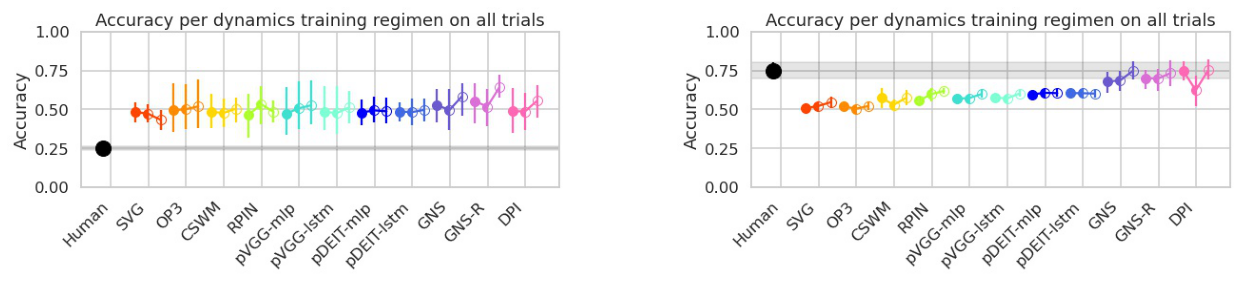

In [87]:
### display side-by-side correlation comparison on adversarial trials only and all trials 
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 22, 16

# read images
img_A = mpimg.imread('training_accu_adv.jpg')
img_B = mpimg.imread('training_accu_all.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[0].axis('off');
ax[1].imshow(img_B);
ax[1].axis('off');

In [88]:
# remove used imgs after use
os.remove("training_accu_all.jpg") 
os.remove("training_accu_adv.jpg") 
print("Image files removed.")

Image files removed.
